# HANC with a Welfare State

**Table of contents**<a id='toc0_'></a>    
- 1. [Setup](#toc1_)    
- 2. [Test 1: Solving and simulating the household problem](#toc2_)    
- 3. [Test 2: Evaluating the objective for finding the steady state](#toc3_)    
- 4. [Find stationary equilibrium](#toc4_)    
- 5. [Grid search](#toc5_)    
- 6. [Policy functions](#toc6_)    
- 7. [Simulation](#toc7_)    
- 8. [Test transition path](#toc8_)    
- 9. [Find transition path](#toc9_)    

<!-- vscode-jupyter-toc-config
	numbering=true
	anchor=true
	flat=false
	minLevel=2
	maxLevel=6
	/vscode-jupyter-toc-config -->
<!-- THIS CELL WILL BE REPLACED ON TOC UPDATE. DO NOT WRITE YOUR TEXT IN THIS CELL -->

In [27]:
%load_ext autoreload
%autoreload 2

import time
import pickle
import numpy as np
from scipy import optimize
from scipy.optimize import minimize_scalar

import matplotlib.pyplot as plt   
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
plt.rcParams.update({"axes.grid" : True, "grid.color": "black", "grid.alpha":"0.25", "grid.linestyle": "--"})
plt.rcParams.update({'font.size': 14})

from HANCWelfareModel import HANCWelfareModelClass
from steady_state import obj_ss

from mpl_toolkits.mplot3d import Axes3D


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## 1. <a id='toc1_'></a>[Setup](#toc0_)

In [28]:
model = HANCWelfareModelClass(name='baseline')

par = model.par
ss = model.ss
sol = model.sol
path = model.path

## 2. <a id='toc2_'></a>[Test 1: Solving and simulating the household problem](#toc0_)

We set all the steady values for the household problem manually at ad hoc values:

In [3]:
ss.r = 0.02*(1-0.1)
ss.wt = 1.00*(1-0.3)
ss.S = 0.0
ss.Chi = 0.1
ss.G = 0.4

model.solve_hh_ss(do_print=True)
model.simulate_hh_ss(do_print=True)


household problem in ss solved in 0.1 secs [334 iterations]
household problem in ss simulated in 1.5 secs [403 iterations]


In [30]:
par.Chi_ = 0.1
par.G_ = 0.4
model.find_ss(do_print=True)


starting at [3.8624]

 message: The solution converged.
 success: True
  status: 1
     fun: [ 1.262e-12 -1.186e-13]
       x: [ 3.257e+00  7.770e-01]
    nfev: 33
    fjac: [[-9.988e-01  4.817e-02]
           [-4.817e-02 -9.988e-01]]
       r: [-1.139e+01 -1.430e+01  1.405e+00]
     qtf: [-2.838e-09  1.244e-10]

steady state found in 5.3 secs
ss.K =  2.475
ss.A_hh =  2.475
ss.L =  1.160
ss.Y =  1.083
ss.r =  0.031
ss.w =  0.998
ss.clearing_A = 1.26e-12
ss.clearing_L = 0.00e+00
ss.clearing_Y = 2.65e-11


In [31]:
def print_ss():
    print(f'Steady state values:')
    for varname in model.varlist:
        print(f'{varname:15s}: {ss.__dict__[varname]:.4f}')
print_ss()

Steady state values:
K              : 2.4754
L_Y            : 0.7599
rK             : 0.1313
w              : 0.9976
Y              : 1.0830
A              : 2.4754
r              : 0.0313
tau            : 0.7770
wt             : 0.2225
L_G            : 0.4000
G              : 0.4000
Chi            : 0.1000
S              : 0.4000
Gamma_G        : 1.0000
A_hh           : 2.4754
C_hh           : 0.4355
ELL_hh         : 1.1758
L_hh           : 1.1599
INC_hh         : 0.4355
U_hh           : -5.7807
L              : 1.1599
I              : 0.2475
clearing_A     : 0.0000
clearing_L     : 0.0000
clearing_Y     : 0.0000
clearing_G     : -0.0000


In [32]:
model.test_path(in_place=True) 

shocks: G L_G Gamma_G 
unknowns: K L_Y 

blocks.production_firm
 rK               0.0e+00
 w                0.0e+00
 Y                0.0e+00
blocks.mutual_fund
 A                0.0e+00
 r                0.0e+00
blocks.government
 tau              0.0e+00
 wt               0.0e+00
 Chi              0.0e+00
 S                0.0e+00
hh
 A_hh             1.2e-09
 C_hh             3.4e-11
 ELL_hh           1.5e-10
 L_hh             1.3e-10
 INC_hh           8.6e-12
 U_hh             3.5e-10
blocks.market_clearing
 L                1.3e-10
 I                2.2e-16
 clearing_A       1.1e-09 [target]
 clearing_L       1.3e-10
 clearing_Y       3.4e-11
 clearing_G       9.8e-11 [target]


In [33]:
print(path.__dict__['clearing_Y'][:10])

[[2.64973599e-11]
 [2.57557309e-11]
 [2.50302001e-11]
 [2.43204346e-11]
 [2.36259901e-11]
 [2.29466446e-11]
 [2.22820651e-11]
 [2.16319185e-11]
 [2.09957607e-11]
 [2.03735917e-11]]


In [34]:
model.compute_jacs(do_print=True)

household Jacobians:
one step deviation from steady state calculated in 0.0 secs
curly_Y and curly_D calculated for Chi             in 0.2 secs
curly_Y and curly_D calculated for S               in 0.2 secs
curly_Y and curly_D calculated for r               in 0.2 secs
curly_Y and curly_D calculated for wt              in 0.2 secs
curly_E calculated in 0.1 secs
builiding blocks combined in 0.2 secs
household Jacobian computed in 1.0 secs

full Jacobians:
full Jacobian to unknowns computed in 0.4 secs [in evaluate_blocks(): 0.3 secs]
full Jacobian to shocks computed in 0.6 secs [in evaluate_blocks(): 0.3 secs]


In [35]:
model.find_transition_path(shocks=[],do_print=True)

finding the transition path:
 it =   0 -> max. abs. error = 1.15e-09
   1.15e-09 in clearing_A
   9.79e-11 in clearing_G
 it =   1 -> max. abs. error = 3.02e-14
   3.02e-14 in clearing_A
   1.69e-14 in clearing_G

transition path found in 0.5 secs


In [36]:
# a. define shock
dG = np.zeros(par.T)
dG[0:9] = 0.1*ss.G
shocks = {'dG':dG} 

# b. find transition path
model.find_transition_path(do_print=True,shocks=shocks)

finding the transition path:
 it =   0 -> max. abs. error = 4.00e-02
   1.15e-09 in clearing_A
   4.00e-02 in clearing_G
 it =   1 -> max. abs. error = 7.26e-03
   7.26e-03 in clearing_A
   6.82e-03 in clearing_G
 it =   2 -> max. abs. error = 1.25e-03
   7.58e-04 in clearing_A
   1.25e-03 in clearing_G
 it =   3 -> max. abs. error = 1.32e-04
   5.22e-05 in clearing_A
   1.32e-04 in clearing_G
 it =   4 -> max. abs. error = 2.83e-05
   1.00e-05 in clearing_A
   2.83e-05 in clearing_G
 it =   5 -> max. abs. error = 4.61e-07
   2.09e-07 in clearing_A
   4.61e-07 in clearing_G
 it =   6 -> max. abs. error = 1.47e-07
   3.82e-08 in clearing_A
   1.47e-07 in clearing_G
 it =   7 -> max. abs. error = 4.44e-09
   1.53e-09 in clearing_A
   4.44e-09 in clearing_G
 it =   8 -> max. abs. error = 8.01e-10
   1.22e-10 in clearing_A
   8.01e-10 in clearing_G
 it =   9 -> max. abs. error = 3.77e-11
   8.45e-12 in clearing_A
   3.77e-11 in clearing_G

transition path found in 1.9 secs


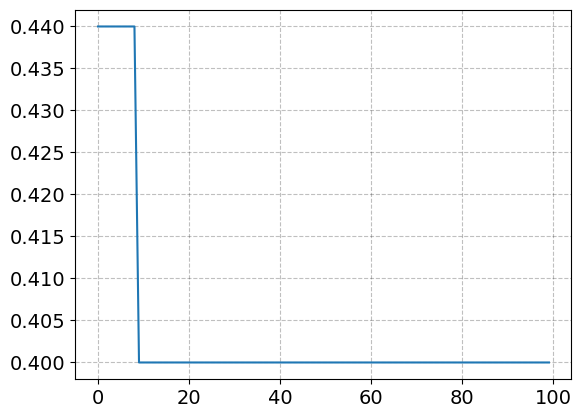

In [37]:
plt.plot(path.G[:100])

linear transition path found in 0.1 secs [finding solution matrix: 0.1 secs]
### shocks ###


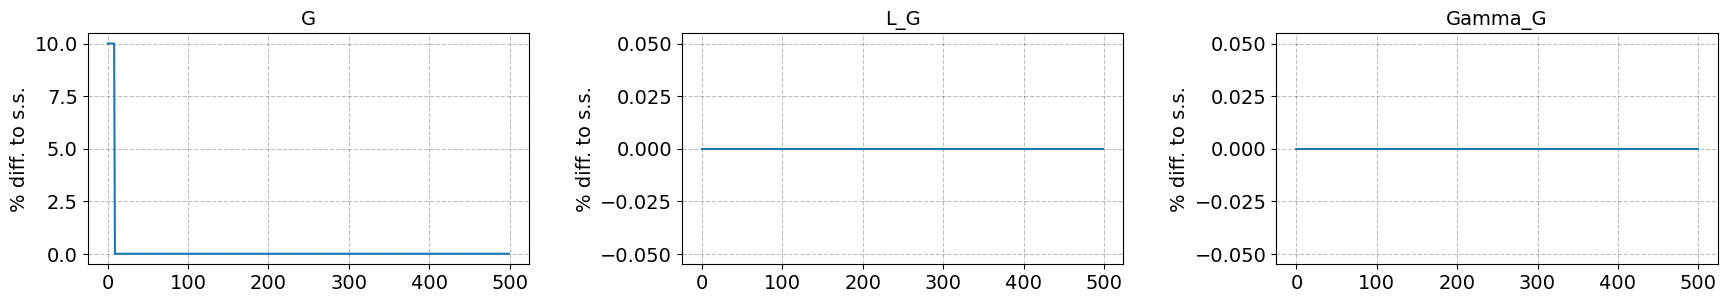


### varnames ###


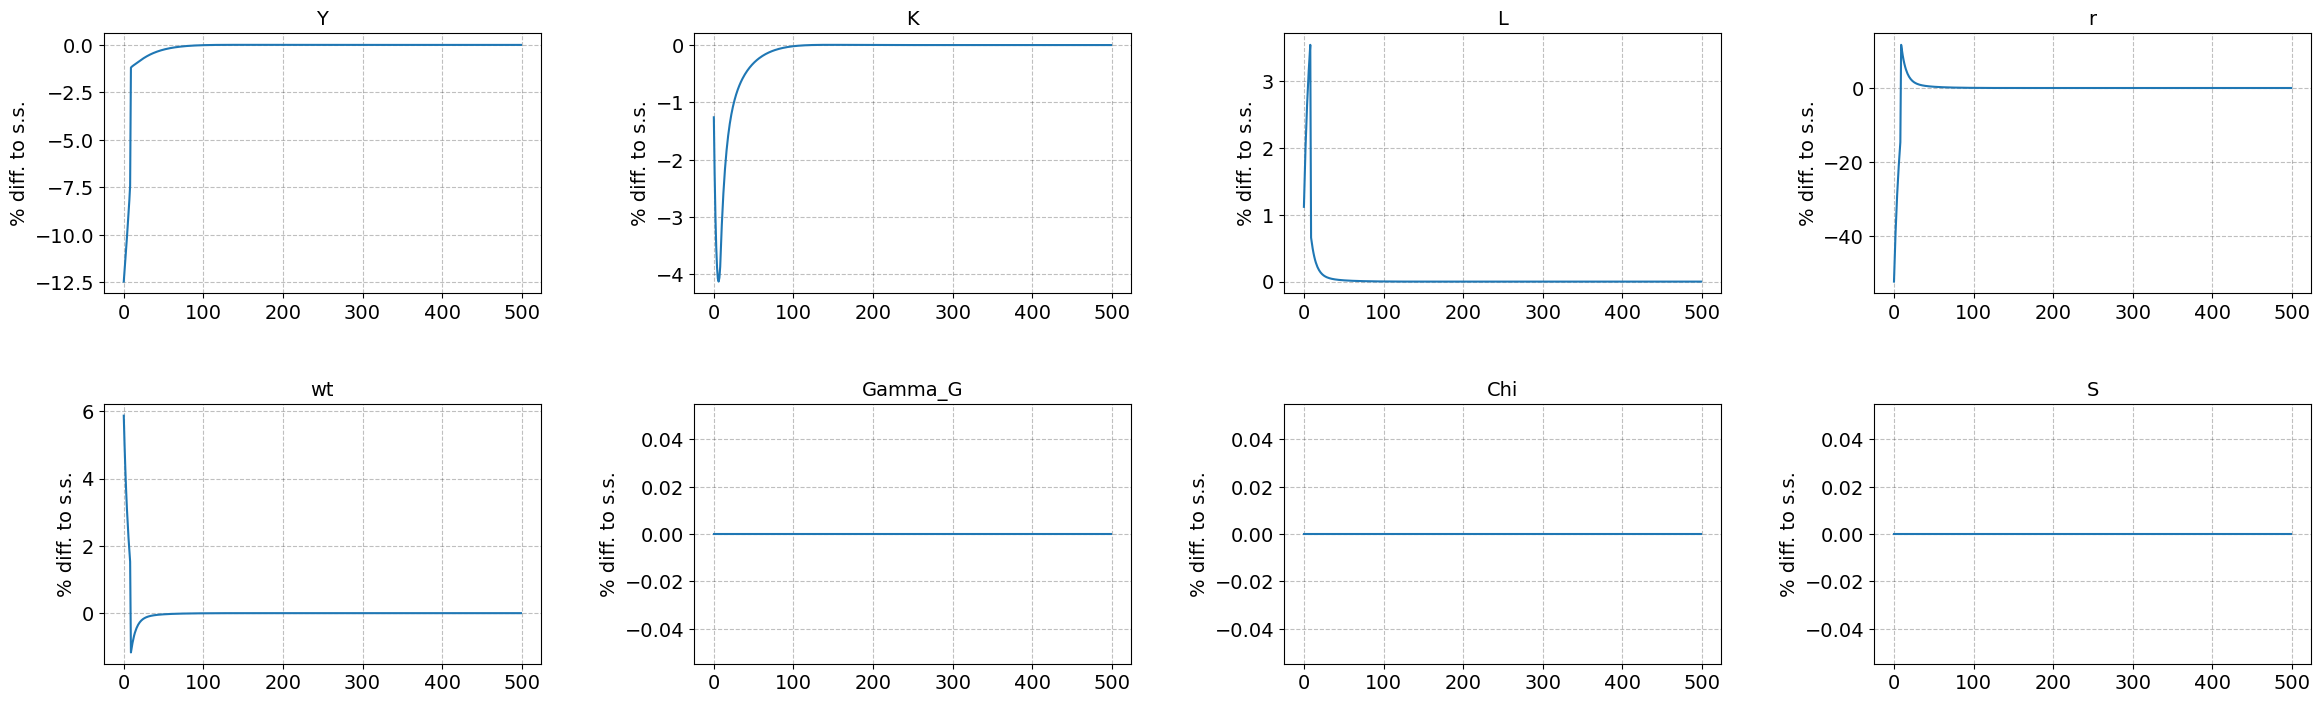


### tagets ###


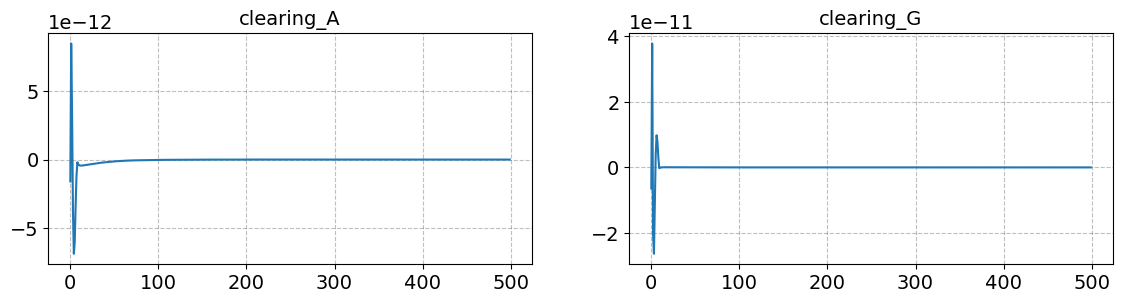

In [38]:
model.find_IRFs(shocks=shocks,do_print=True)
model.show_IRFs(varnames=['Y','K','L','r','wt','Gamma_G','Chi','S'])

# Question a Stationary Equalibrium without gov 

## 1. Steady state values

In [39]:
par.G_ = 0.0
par.Chi_ = 0.0
model.find_ss(do_print=False)
print_ss()

Steady state values:
K              : 3.3887
L_Y            : 0.9225
rK             : 0.1207
w              : 1.0342
Y              : 1.3630
A              : 3.3887
r              : 0.0207
tau            : 0.0000
wt             : 1.0342
L_G            : 0.0000
G              : 0.0000
Chi            : 0.0000
S              : 0.0000
Gamma_G        : 1.0000
A_hh           : 3.3887
C_hh           : 1.0241
ELL_hh         : 0.9897
L_hh           : 0.9225
INC_hh         : 1.0241
U_hh           : -100000001.6179
L              : 0.9225
I              : 0.3389
clearing_A     : 0.0000
clearing_L     : 0.0000
clearing_Y     : 0.0000
clearing_G     : 0.0000


In [14]:
def udskriv():
    with open('output_table.tex', 'w') as file:
        file.write("\\begin{tabular}{l r}\n")
        file.write("\\hline\n")
        file.write("Variable Name & Value \\\\\n")
        file.write("\\hline\n")
        for varname in model.varlist:
            file.write(f'{varname} & {ss.__dict__[varname]:.4f} \\\\\n')
        file.write("\\hline\n")
        file.write("\\end{tabular}\n")
udskriv()

## 2. Policy functions

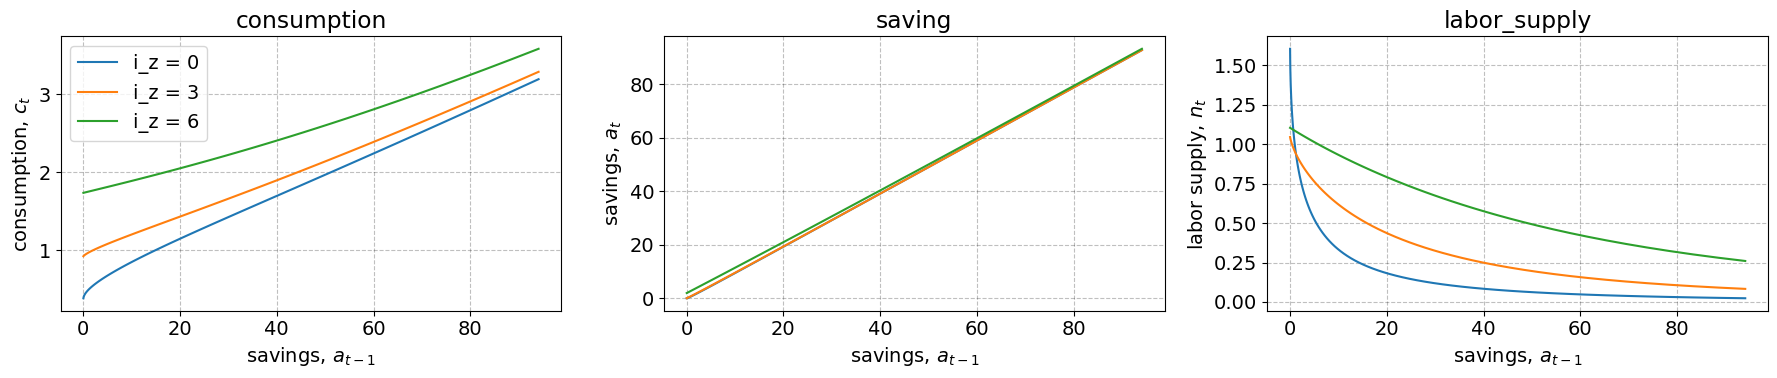

In [15]:
i_fix = 0

fig = plt.figure(figsize=(18,4),dpi=100)
a_max = 100

# a. consumption
I = par.a_grid < a_max

ax = fig.add_subplot(1,3,1)
ax.set_title(f'consumption')

for i_z in [0,par.Nz//2,par.Nz-1]:
    ax.plot(par.a_grid[I],ss.c[i_fix,i_z,I],label=f'i_z = {i_z}')

ax.legend(frameon=True)
ax.set_xlabel('savings, $a_{t-1}$')
ax.set_ylabel('consumption, $c_t$')

# b. saving
I = par.a_grid < a_max

ax = fig.add_subplot(1,3,2)
ax.set_title(f'saving')

for i_z in [0,par.Nz//2,par.Nz-1]:
    ax.plot(par.a_grid[I],ss.a[i_fix,i_z,I],label=f'i_z = {i_z}')

ax.set_xlabel('savings, $a_{t-1}$')
ax.set_ylabel('savings, $a_{t}$')

# c. labor supply
I = par.a_grid < a_max

ax = fig.add_subplot(1,3,3)
ax.set_title(f'labor_supply')

for i_z in [0,par.Nz//2,par.Nz-1]:
    ax.plot(par.a_grid[I],ss.ell[i_fix,i_z,I],label=f'i_z = {i_z}')

ax.set_xlabel('savings, $a_{t-1}$')
ax.set_ylabel('labor supply, $n_{t}$')


fig.tight_layout()
#save figure
#fig.savefig('figs/fig_policy.png', bbox_inches='tight')

plt.show()

## 3. Distribution in ss 

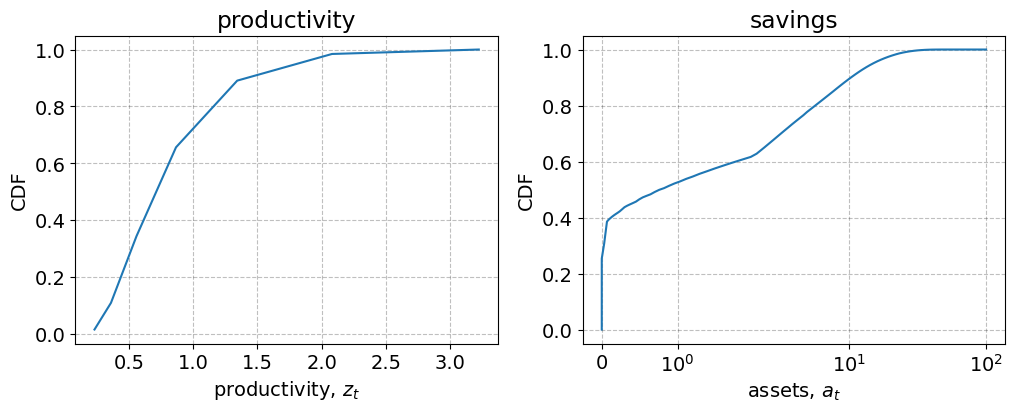

In [16]:
fig = plt.figure(figsize=(12,4),dpi=100)

# a. income
ax = fig.add_subplot(1,2,1)
ax.set_title('productivity')

y = np.cumsum(np.sum(ss.D,axis=(0,2)))
ax.plot(par.z_grid,y/y[-1])

ax.set_xlabel('productivity, $z_{t}$')
ax.set_ylabel('CDF')

# b. assets
ax = fig.add_subplot(1,2,2)
ax.set_title('savings')
y = np.insert(np.cumsum(np.sum(ss.D,axis=(0,1))),0,0.0)
ax.plot(np.insert(par.a_grid,0,par.a_grid[0]),y/y[-1])
        
ax.set_xlabel('assets, $a_{t}$')
ax.set_ylabel('CDF')
ax.set_xscale('symlog')

#save figure
#fig.savefig('figs/fig_distribution.png', bbox_inches='tight')
plt.show()

## 4. Expected discounted utility

Utility: -144.7112


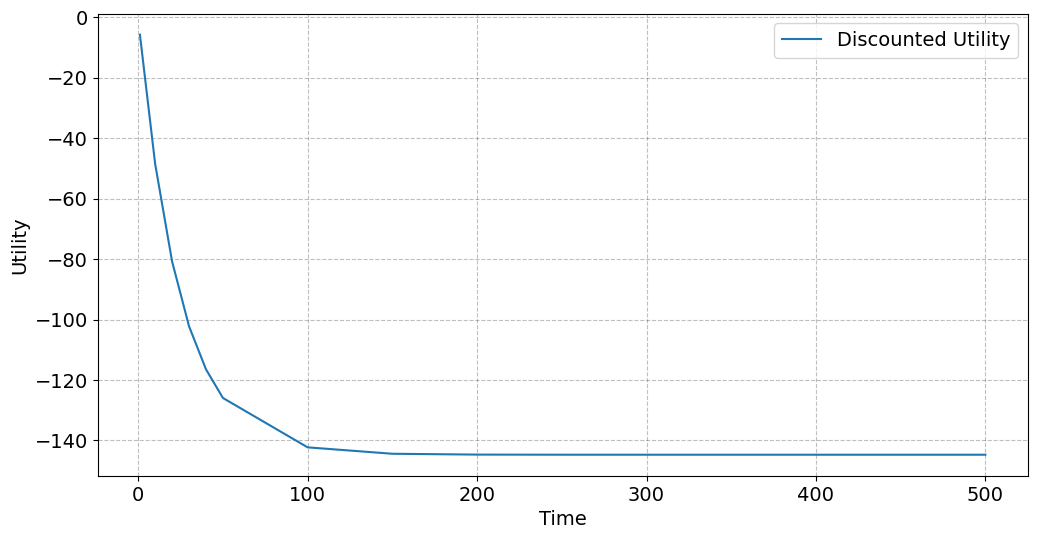

In [17]:
#Ploting the accumulation discounted utility
#par.T = 500
time_ = [1, 10, 20, 30, 40, 50,  100, 150, 200, 250, 300, 350, 400, 450, 500]

time_past = []
disc_utility = []
for i in time_:
    par.T = i 
    time_past.append(i)
    U =np.sum([par.beta**t * np.sum(path.u[t]*path.D[t]/np.sum(path.D[t])) for t in range(par.T)])
    disc_utility.append(U)


print(f'Utility: {disc_utility[-1]:.4f}')

#figure 
fig = plt.figure(figsize=(12,6))
ax = fig.add_subplot(1,1,1)
ax.plot(time_past, disc_utility, label='Discounted Utility')
ax.set_xlabel('Time')
ax.set_ylabel('Utility')
ax.legend()

# save figure
#fig.savefig('figs/fig_disc_utility.png', bbox_inches='tight')
#print(disc_utility)
plt.show()



# 2. 

# STOP 

In [18]:
model.solve_hh_ss(do_print=True)

household problem in ss solved in 0.1 secs [363 iterations]


In [19]:
model.simulate_hh_ss(do_print=True)
print(ss.U_hh)

household problem in ss simulated in 0.0 secs [490 iterations]
-100000001.61794248


In [20]:
#Testting obj function 
# guessing on tau and K/L_y
x = [1.0, 0.0]

obj_ss(x, model)

(-107.33112536245852, 0.0)

In [21]:
model.find_ss(do_print=True)

starting at [3.8624]

 message: The solution converged.
 success: True
  status: 1
     fun: [ 6.999e-13  0.000e+00]
       x: [ 3.673e+00  0.000e+00]
    nfev: 9
    fjac: [[-1.000e+00  0.000e+00]
           [ 0.000e+00 -1.000e+00]]
       r: [-8.480e+00 -2.748e+00  9.816e-01]
     qtf: [-6.223e-08  0.000e+00]

steady state found in 1.4 secs
ss.K =  3.389
ss.A_hh =  3.389
ss.L =  0.923
ss.Y =  1.363
ss.r =  0.021
ss.w =  1.034
ss.clearing_A = 7.00e-13
ss.clearing_L = 0.00e+00
ss.clearing_Y = 3.27e-11


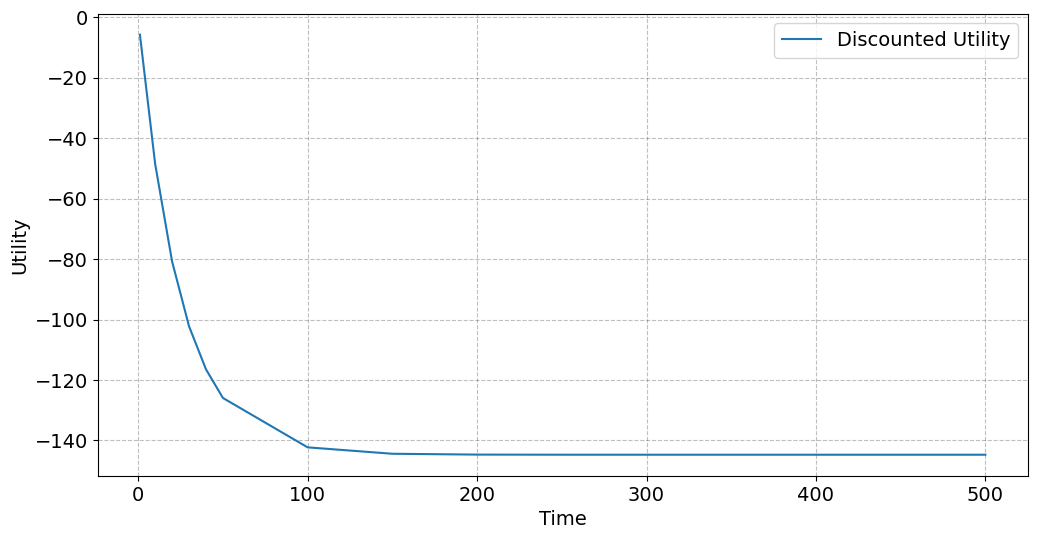

In [22]:
#Ploting the accumulation discounted utility
#par.T = 500
time_ = [1, 10, 20, 30, 40, 50,  100, 150, 200, 250, 300, 350, 400, 450, 500]

time_past = []
disc_utility = []
for i in time_:
    par.T = i 
    time_past.append(i)
    U =np.sum([par.beta**t * np.sum(path.u[t]*path.D[t]/np.sum(path.D[t])) for t in range(par.T)])
    disc_utility.append(U)

#figure 
fig = plt.figure(figsize=(12,6))
ax = fig.add_subplot(1,1,1)
ax.plot(time_past, disc_utility, label='Discounted Utility')
ax.set_xlabel('Time')
ax.set_ylabel('Utility')
ax.legend()

# save figure
#fig.savefig('figs/fig_disc_utility.png', bbox_inches='tight')
#print(disc_utility)
plt.show()


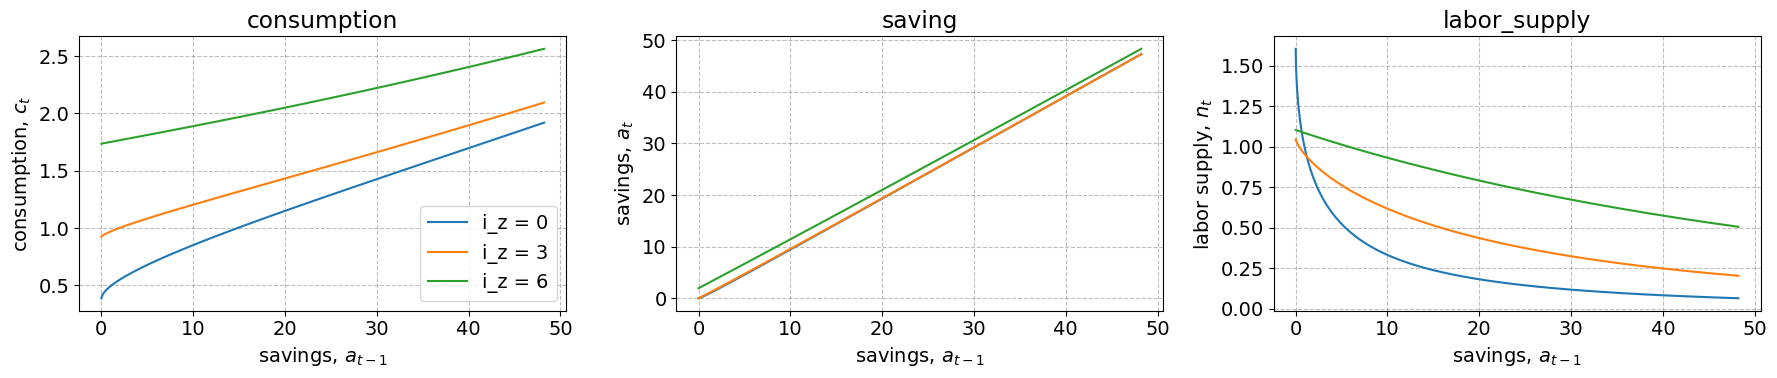

In [23]:
i_fix = 0

fig = plt.figure(figsize=(18,4),dpi=100)
a_max = 50

# a. consumption
I = par.a_grid < a_max

ax = fig.add_subplot(1,3,1)
ax.set_title(f'consumption')

for i_z in [0,par.Nz//2,par.Nz-1]:
    ax.plot(par.a_grid[I],ss.c[i_fix,i_z,I],label=f'i_z = {i_z}')

ax.legend(frameon=True)
ax.set_xlabel('savings, $a_{t-1}$')
ax.set_ylabel('consumption, $c_t$')

# b. saving
I = par.a_grid < a_max

ax = fig.add_subplot(1,3,2)
ax.set_title(f'saving')

for i_z in [0,par.Nz//2,par.Nz-1]:
    ax.plot(par.a_grid[I],ss.a[i_fix,i_z,I],label=f'i_z = {i_z}')

ax.set_xlabel('savings, $a_{t-1}$')
ax.set_ylabel('savings, $a_{t}$')

# c. labor supply
I = par.a_grid < a_max

ax = fig.add_subplot(1,3,3)
ax.set_title(f'labor_supply')

for i_z in [0,par.Nz//2,par.Nz-1]:
    ax.plot(par.a_grid[I],ss.ell[i_fix,i_z,I],label=f'i_z = {i_z}')

ax.set_xlabel('savings, $a_{t-1}$')
ax.set_ylabel('labor supply, $n_{t}$')


fig.tight_layout()
#save figure
#fig.savefig('figs/fig_policy.png', bbox_inches='tight')

plt.show()

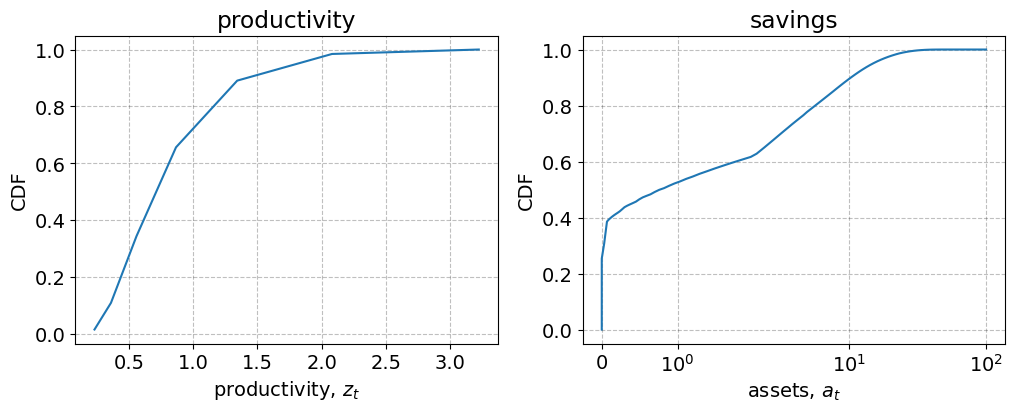

In [24]:
fig = plt.figure(figsize=(12,4),dpi=100)

# a. income
ax = fig.add_subplot(1,2,1)
ax.set_title('productivity')

y = np.cumsum(np.sum(ss.D,axis=(0,2)))
ax.plot(par.z_grid,y/y[-1])

ax.set_xlabel('productivity, $z_{t}$')
ax.set_ylabel('CDF')

# b. assets
ax = fig.add_subplot(1,2,2)
ax.set_title('savings')
y = np.insert(np.cumsum(np.sum(ss.D,axis=(0,1))),0,0.0)
ax.plot(np.insert(par.a_grid,0,par.a_grid[0]),y/y[-1])
        
ax.set_xlabel('assets, $a_{t}$')
ax.set_ylabel('CDF')
ax.set_xscale('symlog')

#save figure
#fig.savefig('figs/fig_distribution.png', bbox_inches='tight')
plt.show()

## Question 2 optimal government

In [25]:
# New objetctiv function
def u_gov(x):
    par.G_ss = x
    model.find_ss(do_print=False)
    return ss.U_hh

def obj_gov(x):
    return - u_gov(x)

In [26]:
# Optimize the objective function within the specified range

result = minimize_scalar( obj_gov, bounds=(0.375, 0.45), method='bounded')

# Print the optimization result
print(f"Optimal value of x: {- result.x}, given Chi = {ss.Chi}")
print(f"Optimal objective function value: {- result.fun}")


KeyboardInterrupt: 

In [ ]:
# G/Y in the steady state
# PROBLEM - G in the steady state: 1.22 skal være 0.41493
print(f"G/Y in the steady state: {ss.G/ss.Y}")
print(f"L_G in the steady state: {ss.L_G}")
print(f"G in the steady state: {ss.Y}")
print(f"Y in the steady state: {ss.Gamma_G}")
print(f'S in the steady state: {ss.S}')
print(f'Chi in the steady state: {ss.Chi}')
print(f'U_hh in the steady state: {ss.U_hh}')
print(f'G_ss in the steady state: {par.G_ss}')

In [ ]:
# Error  RuntimeWarning: invalid value encountered in double_scalars
# Create the figure and subplots
fig = plt.figure(figsize=(10, 10), dpi=100)

#
ax = fig.add_subplot(1, 1, 1)
ax.set_title('Productivity')


g_values = np.linspace(0.3, 0.5, 20)
u_values = [u_gov(x) for x in g_values]


# Plot the objective function
ax.plot(g_values, u_values, label='Objective Function')
ax.set_xlabel('Government production')
ax.set_ylabel('Discounted expected utility')
ax.set_title('Plot of Objective Function')
ax.grid(True)
ax.legend()

# Plot the minimum point
ax.scatter(result.x, u_gov(result.x), color='red', label='Optimal government consumption', marker='o')
ax.legend()

# Save figure
fig.savefig('figs/fig_optimal_G.png', bbox_inches='tight')

# Show the figure
plt.show()


## Question 3

In [ ]:
# Optimize the objective function within the specified range
par.Chi_ss = 0.05

result = minimize_scalar( obj_gov, bounds=(0.375, 0.45), method='bounded')

# Print the optimization result
print(f"Optimal value of x: {- result.x}, given Chi = {ss.Chi}")
print(f"Optimal objective function value: {- result.fun}")

# G/Y in the steady state
# PROBLEM - G in the steady state: 1.22 skal være 0.41493
print(f"G/Y in the steady state: {ss.G/ss.Y}")
print(f"L_G in the steady state: {ss.L_G}")
print(f"G in the steady state: {ss.Y}")
print(f"Y in the steady state: {ss.Gamma_G}")
print(f'S in the steady state: {ss.S}')
print(f'Chi in the steady state: {ss.Chi}')
print(f'U_hh in the steady state: {ss.U_hh}')
print(f'G_ss in the steady state: {par.G_ss}')

In [ ]:
# Error  RuntimeWarning: invalid value encountered in double_scalars
# Create the figure and subplots
fig = plt.figure(figsize=(10, 10), dpi=100)

#
ax = fig.add_subplot(1, 1, 1)
ax.set_title('Productivity')

g_values = np.linspace(0.3, 0.5, 10)
u_values = [u_gov(x) for x in g_values]


# Plot the objective function
ax.plot(g_values, u_values, label='Objective Function')
ax.set_xlabel('Government production')
ax.set_ylabel('Discounted expected utility')
ax.set_title('Plot of Objective Function')
ax.grid(True)
ax.legend()

# Plot the minimum point
ax.scatter(result.x, u_gov(result.x), color='red', label='Optimal government consumption', marker='o')
ax.legend()

# Save figure
#fig.savefig(f'figs/fig_optimal_G_{ss.Chi}.png', bbox_inches='tight')

# Show the figure
plt.show()


In [ ]:
# Define Chi and G values more densely for a smooth surface
#Chi_values = np.linspace(0.0, 0.1, 2)  # Increased number of points for smoothness
#G_values = np.linspace(0.4, 0.4, 2)


# Create a meshgrid
#Chi_grid, G_grid = np.meshgrid(Chi_values, G_values)

print(f'Chi_grid: {Chi_grid}')
print(f'Chi_grid: {G_grid}')
print(f'U_grid: {U_grid}')

In [ ]:
# Define Chi and G values more densely for a smooth surface
Chi_values = np.linspace(0.0, 0.1, 2)  # Increased number of points for smoothness
G_values = np.linspace(0.4, 0.4, 2)


# Create a meshgrid
Chi_grid, G_grid = np.meshgrid(Chi_values, G_values)

# Initialize an empty grid for U values
U_grid = np.zeros_like(Chi_grid)

# Compute U values for each combination of Chi and G
for i in range(Chi_grid.shape[0]):
    for j in range(G_grid.shape[1]):

        par.Chi_ss = Chi_grid[i, j]
        par.G_ss = G_grid[i, j]
        model.find_ss(do_print=False)
        U_grid[i, j] = ss.U_hh

In [ ]:
# Plotting
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Surface plot with color based on U values
surface = ax.plot_surface(Chi_grid, G_grid, U_grid, cmap='viridis')

# Adding a color bar
cbar = plt.colorbar(surface)
cbar.set_label('U values')

# Labeling axes
ax.set_xlabel('Chi')
ax.set_ylabel('G')
ax.set_zlabel('U')

# Show plot
plt.show()

In [ ]:


# Define Chi and G values more densely for a smooth surface
Chi_values = np.linspace(0.0, 0.1, 5)  # Increased number of points for smoothness
G_values = np.linspace(0.3, 0.5, 5)

# Create a meshgrid
Chi_grid, G_grid = np.meshgrid(Chi_values, G_values)

# Initialize an empty grid for U values
U_grid = np.zeros_like(Chi_grid)

# Compute U values for each combination of Chi and G
for i in range(Chi_grid.shape[0]):
    for j in range(G_grid.shape[1]):
        par.Chi_ss = Chi_grid[i, j]
        par.G_ss = G_grid[i, j]
        model.find_ss(do_print=False)
        U_grid[i, j] = ss.U_hh

# Plotting
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Surface plot with color based on U values
surface = ax.plot_surface(Chi_grid, G_grid, U_grid, cmap='viridis')

# Adding a color bar
cbar = plt.colorbar(surface)
cbar.set_label('U values')

# Labeling axes
ax.set_xlabel('Chi')
ax.set_ylabel('G')
ax.set_zlabel('U')

# Show plot
plt.show()


In [ ]:
from mpl_toolkits.mplot3d import Axes3D

# ... [your code to compute Chi_list, G_list, U_list] ...

# Plotting
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Scatter plot with color based on U values
scatter = ax.scatter(Chi_list, G_list, U_list, c=U_list, cmap='viridis')

# Adding a color bar
cbar = plt.colorbar(scatter)
cbar.set_label('U values')

# Labeling axes
ax.set_xlabel('Chi')
ax.set_ylabel('G')
ax.set_zlabel('U')

# Show plot
plt.show()

In [ ]:
# Optimizing over 3 dimensions
Chi_values = np.linspace(0.0, 0.5, 5)
G_values = np.linspace(0.3, 0.5, 5)
u_values = []

par.Chi_ss = i
par.G_ss = j 
model.find_ss(do_print=True)
ss.U_hh

## 2. <a id='toc2_'></a>[Test 1: Solving and simulating the household problem](#toc0_)

In [ ]:
model.compute_jacs(do_print=True)
model.test_jacs()

In [ ]:
model.test_path()

In [ ]:
model.find_transition_path(shocks=[],do_print=True)

## Question 2

In [ ]:
ss.U_hh

In [ ]:
#Works 
par.G_ss = 0.2
model.find_ss(do_print=False)
print(f'{ss.U_hh = :.2f}')
values = (0.0, 0.1, 0.15, 0.2, 0.25, 0.3)

#dosent work (says float cant be interpreted as an integer)
for i in values:
    print(type(i))
    par.G_ss = i
    model.find_ss(do_print=True)
    print(f'{ss.U_hh = :.2f}')
    print(f'{par.G_ss = :.2f}')
    print(f'{ss.L_G = :.2f}')

In [ ]:
values = (0.1, 0.15, 0.2, 0.25, 0.3)

for i in values:
    print(f'G = {i}')
    par.G_ss = i
    model.find_ss(do_print=False)
    print(f'Utility = {ss.U_hh:.2f}')

In [ ]:
# List of values
values = [0.001, 0.005, 0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.4, 0.5]

# Initialize empty lists to store inputs and utilities
inputs = []
utilities = []

# Iterate through the values
for i in values:
    print(f'G = {i}')
    par.G_ss = i
    model.find_ss(do_print=False)
    utility = ss.U_hh
    print(f'Utility = {utility:.2f}')
    print(f'{ss.L_G = :.2f}')
    print(f'{ss.L_Y = :.2f}')
    
    # Append the input value and utility to the respective lists
    inputs.append(i)
    utilities.append(utility)

# Plot the inputs and utilities
plt.figure(figsize=(8, 4))
plt.plot(inputs, utilities, marker='o', linestyle='-')
plt.xlabel('G')
plt.ylabel('Utility')
plt.title('Utility vs. G')
plt.grid(True)
plt.show()

And we can check whether the results make sort of sense:

In [ ]:
print(f'{model.ss.A_hh = :.2f}')
print(f'{model.ss.L_hh = :.2f}')
print(f'{model.ss.C_hh = :.2f}')

In [ ]:
model.test_hh_path()

## 3. <a id='toc3_'></a>[Test 2: Evaluating the objective for finding the steady state](#toc0_)

We can try out various inputs and look at the outputs:

In [ ]:
#Testting obj function 
# guessing on tau and K/L_y
x = [1.0, 0.0]

obj_ss(x, model)

## 4. <a id='toc4_'></a>[Find stationary equilibrium](#toc0_)

In [ ]:
model.find_ss(do_print=True)

## 5. <a id='toc5_'></a>[Grid search](#toc0_)

In [ ]:
par.tau_ss = 0.0
KL_min = ((1/par.beta+par.delta-1)/(par.alpha*par.Gamma_Y))**(1/(par.alpha-1))
KL_max = (par.delta/(par.alpha*par.Gamma_Y))**(1/(par.alpha-1))

In [ ]:
NKL = 10
KL_vec = np.hstack((np.linspace(KL_min+1e-2,KL_max-1e-2,NKL),np.linspace(KL_max+1e-2,10.0,NKL)))
clearing_A_vec = np.nan*np.ones(KL_vec.size)
r_vec = np.nan*np.ones(KL_vec.size)

model_ = model.copy()
for i,KL in enumerate(KL_vec):
    print(f'{KL = :6.2f}: ',end='')
    try:
        clearing_A_vec[i] = obj_ss(np.array([KL]),model_,do_print=False)
        r_vec[i] = model_.ss.r
        print(f'clearing_A = {clearing_A_vec[i]:16.8f}')
    except Exception as e:
        print(e)

In [ ]:
fig = plt.figure(figsize=(12,4),dpi=100)

# a. income
ax = fig.add_subplot(1,2,1)
ax.set_title('$B+K-A^{hh}$')
ax.plot(KL_vec[:NKL],clearing_A_vec[:NKL],'-o')
ax.plot(KL_vec[NKL:],clearing_A_vec[NKL:],'-o')
ax.axvline(ss.K/ss.L,color='black')
ax.set_yscale('symlog')

ax = fig.add_subplot(1,2,2)
ax.set_title('$r$')
ax.plot(KL_vec[:NKL],r_vec[:NKL],'-o')
ax.plot(KL_vec[NKL:],r_vec[NKL:],'-o')
ax.axvline(ss.K/ss.L,color='black');
ax.axhline(ss.r,color='black');

## 6. <a id='toc6_'></a>[Policy functions](#toc0_)

In [ ]:
i_fix = 0

fig = plt.figure(figsize=(18,4),dpi=100)
a_max = 50

# a. consumption
I = par.a_grid < a_max

ax = fig.add_subplot(1,3,1)
ax.set_title(f'consumption')

for i_z in [0,par.Nz//2,par.Nz-1]:
    ax.plot(par.a_grid[I],ss.c[i_fix,i_z,I],label=f'i_z = {i_z}')

ax.legend(frameon=True)
ax.set_xlabel('savings, $a_{t-1}$')
ax.set_ylabel('consumption, $c_t$')

# b. saving
I = par.a_grid < a_max

ax = fig.add_subplot(1,3,2)
ax.set_title(f'saving')

for i_z in [0,par.Nz//2,par.Nz-1]:
    ax.plot(par.a_grid[I],ss.a[i_fix,i_z,I],label=f'i_z = {i_z}')

ax.set_xlabel('savings, $a_{t-1}$')
ax.set_ylabel('savings, $a_{t}$')

# c. labor supply
I = par.a_grid < a_max

ax = fig.add_subplot(1,3,3)
ax.set_title(f'labor_supply')

for i_z in [0,par.Nz//2,par.Nz-1]:
    ax.plot(par.a_grid[I],ss.ell[i_fix,i_z,I],label=f'i_z = {i_z}')

ax.set_xlabel('savings, $a_{t-1}$')
ax.set_ylabel('labor supply, $n_{t}$')

fig.tight_layout()
plt.show()

## 7. <a id='toc7_'></a>[Simulation](#toc0_)

In [ ]:
fig = plt.figure(figsize=(12,4),dpi=100)

# a. income
ax = fig.add_subplot(1,2,1)
ax.set_title('productivity')

y = np.cumsum(np.sum(ss.D,axis=(0,2)))
ax.plot(par.z_grid,y/y[-1])

ax.set_xlabel('productivity, $z_{t}$')
ax.set_ylabel('CDF')

# b. assets
ax = fig.add_subplot(1,2,2)
ax.set_title('savings')
y = np.insert(np.cumsum(np.sum(ss.D,axis=(0,1))),0,0.0)
ax.plot(np.insert(par.a_grid,0,par.a_grid[0]),y/y[-1])
        
ax.set_xlabel('assets, $a_{t}$')
ax.set_ylabel('CDF')
ax.set_xscale('symlog')

## 8. <a id='toc8_'></a>[Test transition path](#toc0_)

In [ ]:
try:
    model.test_ss()
except Exception as e:
    print('you need to update GEModelTools to call this function (optional)')

In [ ]:
model.test_hh_path()

In [ ]:
model.draw_DAG()

In [ ]:
model.ss.tau

In [ ]:
model.test_path(in_place=True)

In [ ]:
model.path.A_hh

## 9. <a id='toc9_'></a>[Find transition path](#toc0_)

In [ ]:
model.compute_jacs(do_print=True)
model.find_transition_path(shocks=[],do_print=True)

In [ ]:
model.test_jacs()

In [ ]:
model.find_transition_path(shocks=[],do_print=True)

## 9. <a id='toc9_'></a>[Question a](#toc0_)

Calculating utility

In [ ]:
par.T = 500
v = np.sum([par.beta**t* np.sum(path.u[t,i_fix]*path.D[t,i_fix]/np.sum(path.D[t,i_fix]))
for t in range(par.T)])

print(f'{v = :.2f}')